<b>Kaggle Digit Recognizer</b>
<br>
This is my submission for the Kaggle digit recognizer competition. This is based on <a href="https://www.kaggle.com/yassineghouzam">Yassine Ghouzam's </a> implementation with my custom architecture. This utilizes the keras functional API. 
<br>
This implementation achieved a score of 0.99586 <b>(top 8%)</b>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [19]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

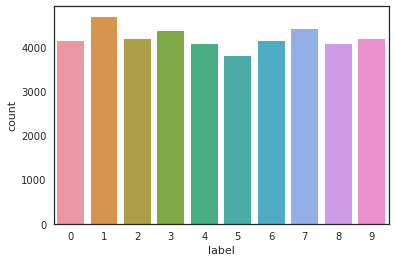

In [20]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [21]:
X_train.shape

(42000, 784)

In [14]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [15]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [16]:
# Gray scale Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [26]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [27]:
X_train.shape


(42000, 28, 28, 1)

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
# Set the random seed
random_seed = 2

In [10]:
# Split the train and the validation set for the fitting 10% val
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

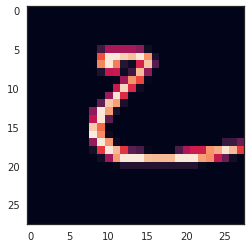

In [11]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [12]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [40]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def my_model(preload = None):
    
    inputs = Input(shape=(28,28,1))
    
    conv1 = Conv2D(32,(3,3),padding='same')(inputs)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    
    conv1 = Conv2D(32,(3,3),padding='same')(conv1)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    
    pool1 = MaxPool2D((2,2),padding='same')(conv1)
    pool1 = Dropout(0.2)(pool1)
    
    conv2 = Conv2D(64,(3,3),padding='same')(pool1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    
    conv2 = Conv2D(64,(3,3),padding='same')(conv2)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    
    pool2 = MaxPool2D((2,2),padding='same')(conv2)
    pool2 = Dropout(0.2)(pool2)

    flat = Flatten()(pool2)
    
    dense = Dense(256,activation = 'relu')(flat)
    
    out = Dense(10,activation='softmax')(dense)
    
    model = Model(inputs,out)
    
    if preload:
        model.load_weights(preload)
    
    return model

In [30]:
# Define the optimizer
optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)

In [31]:
bestval = ModelCheckpoint('bestval.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)


In [41]:
# Compile the model
model = my_model()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
epochs = 35 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [37]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,bestval])

Epoch 1/35
390/390 [==============================] - 73s - loss: 0.0408 - acc: 0.9870 - val_loss: 0.0237 - val_acc: 0.9929
Epoch 2/35
390/390 [==============================] - 72s - loss: 0.0398 - acc: 0.9872 - val_loss: 0.0232 - val_acc: 0.9932
Epoch 3/35
390/390 [==============================] - 66s - loss: 0.0398 - acc: 0.9874 - val_loss: 0.0234 - val_acc: 0.9932
Epoch 4/35
390/390 [==============================] - 66s - loss: 0.0409 - acc: 0.9875 - val_loss: 0.0230 - val_acc: 0.9932
Epoch 5/35
390/390 [==============================] - 67s - loss: 0.0411 - acc: 0.9872 - val_loss: 0.0231 - val_acc: 0.9932
Epoch 6/35
390/390 [==============================] - 66s - loss: 0.0387 - acc: 0.9883 - val_loss: 0.0231 - val_acc: 0.9933
Epoch 7/35
390/390 [==============================] - 69s - loss: 0.0398 - acc: 0.9879 - val_loss: 0.0233 - val_acc: 0.9930
Epoch 8/35
390/390 [==============================] - 69s - loss: 0.0401 - acc: 0.9871 - val_loss: 0.0229 - val_acc: 0.9931
Epoch 9/

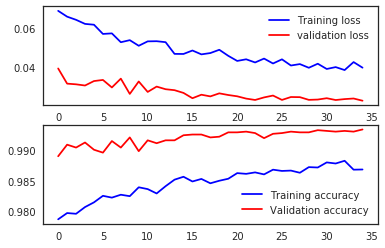

In [39]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
model.load_weights('bestval.h5')

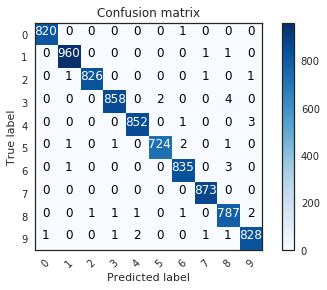

In [21]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

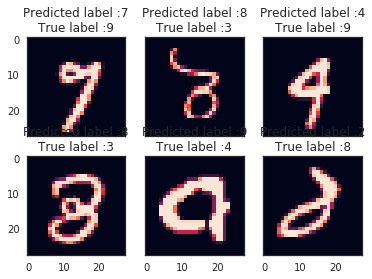

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [25]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [27]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submit.csv",index=False)